## Project: Lending Club Loan Dataset - Case Study

**Author**: Jingwen Wang (jw3667) <br>
**Contact**: jw3667@columbia.edu

## 1. Introduction /Data Description /Business Objectives

**Background**:

[Lending Club Loan Dataset](https://www.kaggle.com/wordsforthewise/lending-club) has been popular on Kaggle platform as data challenges. LendingClub is a peer-to-peer lending platform who enables borrowers to issue unsecured personal loans. On the other side, investors can search and browse the loan listings on LendingClub website and select loans that they wanted to invest in based on the information supplied about the borrower, amount of loan, loan grade, and loan purpose.LendingClub makes profit by charging borrowers an origination fee and investors a service fee. This case study is based on the information provided through Kaggle competition, and it aims to explore about what distinguish `good` borrowers vs. `bad` borrowers in general.

**Dataset Description**

LendingClub data packages provides two seperated datasets on loans were accepted and loans were rejected. To study the characteristic of what can potentially help investors understand what loans are worth investing, `accepted loans` population is selected as base. By evaluating data elements in `accepted_2007_to_2018Q4` dataset, the current status of loan `loan_status` is identified as target variable. Details are contained in the body part of this analysis.

**Business Objectives**

Intuitively, once a loan is accepted by business, there will be two outcomes at the end of its lifecycle: fully paid vs. charge-off (i.e. loss incurred). From investors perspective, there will be loss if the loan defaulted and there is no remaining cash flows coming to the end. By this case study, we want to understand what can help invrstors to identify `loans that are likely to be paid in full` vs. `loans that are likely to defaults with loss`. 

## 2. Analysis Content

### 2.1: Set-up Configures / Load Data

In [160]:
import pandas as pd
import numpy as np
import os
from zipfile import ZipFile
from Utilities.data_preprocessing import *
from Utilities.feature_selection import *
from Utilities.feature_visualization import *
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
from xgboost import XGBClassifier

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_rows', 170)
pd.set_option('display.float', '{:.5f}'.format)
pd.set_option('display.max_colwidth', -1)

%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [161]:
%autoreload 2

**Import Data**

In [3]:
zip_path = 'Dataset/Lending_club_loan_data.zip'
with ZipFile(zip_path, 'r') as zip:
    for info in zip.infolist():
        print(info.filename)

accepted_2007_to_2018Q4.csv.gz
accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv
rejected_2007_to_2018Q4.csv.gz
rejected_2007_to_2018q4.csv/rejected_2007_to_2018Q4.csv


In [4]:
zip_file = ZipFile(zip_path)
file_path = 'accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv'
data_raw = pd.read_csv(zip_file.open(file_path), low_memory=False)
print('data dimension:', data_raw.shape)

data dimension: (2260701, 151)


In [162]:
dict_path = 'Dataset/LCDataDictionary.xlsx'
data_dict = pd.read_excel(dict_path, sheet_name='LoanStats')
display(data_dict.head(10))

,LoanStatNew,Description
0,acc_now_delinq,The number of accounts on which the borrower is now delinquent.
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan application
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by the borrower during registration.
5,annual_inc_joint,The combined self-reported annual income provided by the co-borrowers during registration
6,application_type,Indicates whether the loan is an individual application or a joint application with two co-borrowers
7,avg_cur_bal,Average current balance of all accounts
8,bc_open_to_buy,Total open to buy on revolving bankcards.
9,bc_util,Ratio of total current balance to high credit/credit limit for all bankcard accounts.


**Check Target Variable Availability**

Remove loan status other than *`Fully Paid`* and *`Charged Off`* as its final status has not yet reached.

In [5]:
print(data_raw.loan_status.value_counts())
data = data_raw[data_raw.loan_status.isin(['Fully Paid', 'Charged Off'])]
print('new data dimension:', data.shape)

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: loan_status, dtype: int64
new data dimension: (1345310, 151)


**Preliminary seperation on numerical vs. categorical features**

In [6]:
data = data.set_index('id')
data_float = data.select_dtypes(include='float64')
data_obj = data.select_dtypes(include='object')
print(f'number of float features: {data_float.shape[1]}\nnumber of object features: {data_obj.shape[1]}')

number of float features: 113
number of object features: 37


**Output Value Summary Table**: <br>
`Value Summary Table` contains basic statistics (number of missings, min, q1, median, q3, max, skewness), which will be used to first evaluate the data quality and to determine data cleaning rules. 

**Example of Value Summary Output**

In [82]:
value_summary(df=data_float,dtype='numeric').head(10)

,null_num,null_rate,unique_vals,min,qt_25,median,qt_75,max,skew
out_prncp_inv,0,0.00000,1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
policy_code,0,0.00000,1,1.00000,1.00000,1.00000,1.00000,1.00000,0.00000
delinq_amnt,0,0.00000,2005,0.00000,0.00000,0.00000,0.00000,249925.00000,94.59917
last_fico_range_low,0,0.00000,71,0.00000,625.00000,690.00000,730.00000,845.00000,-3.23377
last_fico_range_high,0,0.00000,72,0.00000,629.00000,694.00000,734.00000,850.00000,-0.60033
last_pymnt_amnt,0,0.00000,693278,0.00000,398.52000,2042.05000,8250.57000,42192.05000,1.78523
collection_recovery_fee,0,0.00000,146053,0.00000,0.00000,0.00000,0.00000,7174.71900,8.73732
recoveries,0,0.00000,132470,0.00000,0.00000,0.00000,0.00000,39859.55000,8.19055
total_rec_late_fee,0,0.00000,15929,-0.00000,0.00000,0.00000,0.00000,1188.83000,18.91137
total_rec_int,0,0.00000,517185,0.00000,766.96000,1569.77000,3031.37000,28192.50000,2.64366


In [83]:
value_summary(df=data_obj,dtype='categorical').head(10)

,null_num,null_rate,unique_vals
term,0,0.00000,2
earliest_cr_line,0,0.00000,739
addr_state,0,0.00000,51
application_type,0,0.00000,2
purpose,0,0.00000,14
hardship_flag,0,0.00000,1
url,0,0.00000,1345310
initial_list_status,0,0.00000,2
pymnt_plan,0,0.00000,1
issue_d,0,0.00000,139


### 2.2 Data Pre-processing

**Data Pre-processing**:
1. Remove variables has no/limited/mis-leading information:
    - remove variables have only one value over the entire population
    - remove categorical variables with sparse values: `url`, `zip_code`, `title`, `emp_title`, `desc`, `sub_grade`
    - remove variables recorded after charge-off: values assocated with `hardship` and `settlement`
<br>
<br>
2. Convert date variables into relatvie months (2000-Jan as reference date)
<br>
<br>
3. Convert US state zip code into census-regions:
    - conversion mapping is downloaded from: [census-region]('https://raw.githubusercontent.com/cphalpert/census-regions/master/us%20census%20bureau%20regions%20and%20divisions.csv')
    - reduce sparsity while remain information relevancy

In [9]:
new_data = data_preprocessing(data)
new_data_float = new_data.select_dtypes(include='float64')
new_data_obj = new_data.select_dtypes(include='object')
print(f'number of float features: {new_data_float.shape[1]}\nnumber of object features: {new_data_obj.shape[1]}')

number of float features: 87
number of object features: 11


### 2.3 Feature Engineering

**Categorical Variables**:
1. Fill `NA` with `'missing'` as a separate value
2. identify ordinal variables: `'term', 'grade', 'emp_length'` and apply OrdinalEncoder to transform the variables
3. apply OneHotEncoder to remaining categorical variables
<br>
**Numerical Variables**:
1. Missing Value imputation:
    - For variables with missing rate < 50%, fill `NA` with `median`
    - For variables with missing rate > 50%, create a corresponding missing indicator, and fill `NA` with `0`
2. Imbalanced Features:
    - For variables with imbalanced distribution (i.e. quantile75% = min), categorize variable into: `missing`, `mode`, `other value`
3. Extreme Values:
    - Calculate IQR (interquartile range) and replace extreme value with `[Q1-1.5*IQR ,Q3+1.5*IQR]`

In [12]:
X, y = new_data.drop(columns=['loan_status']), new_data[['loan_status']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10)
print(f'train size: {X_train.shape[0]}\ntest size: {X_test.shape[0]}')

train size: 1210779
test size: 134531


In [13]:
new_X_train, new_X_test, new_y_train, new_y_test = feature_engineering(X_train, X_test, y_train, y_test)

**example of feature engineer**:

In [129]:
plot_data = pd.concat([new_X_train, new_y_train], axis=1)
plot_data['loan_status'] = plot_data['loan_status'].map({0: 'Fully Paid', 1: 'Charged Off'})

<AxesSubplot:xlabel='grade', ylabel='count'>

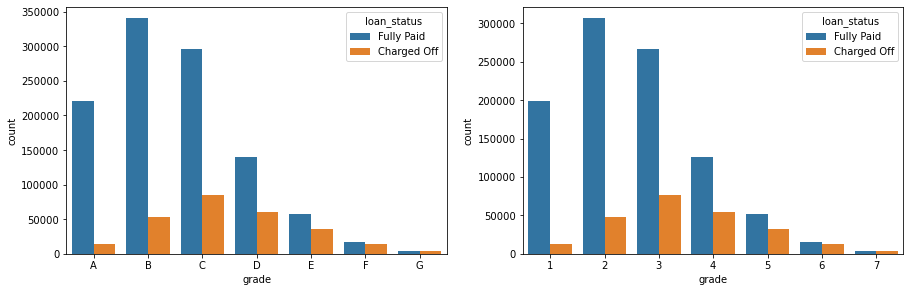

In [130]:
plot_data_processing_cat(df1=data, df2=plot_data, var='grade')

<AxesSubplot:xlabel='annual_inc', ylabel='Probability'>

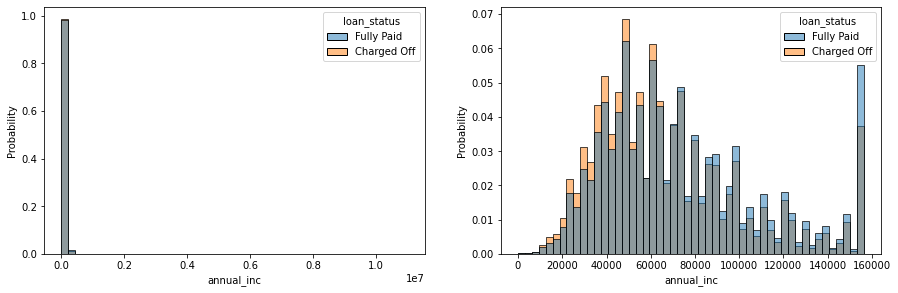

In [138]:
plot_data_processing_num(df1=data, df2=plot_data, var='annual_inc')

### 2.4. Variable Clustering

Agglomerative hierachical clustering algorithm is applied to group features based on correlation. Key takaways are as follow:
- `min_corr`: set threshold as the minimum pair-wise correlation within the group under each cluster
- By setting correlation = 0.7, we get 95 clusters out of XX features, which indicating that input features do not suffer from severe multi-colinearity. However, given the correlated nature in finance data, we decide to use model less sensitive to highly correlated variables to keep available information.

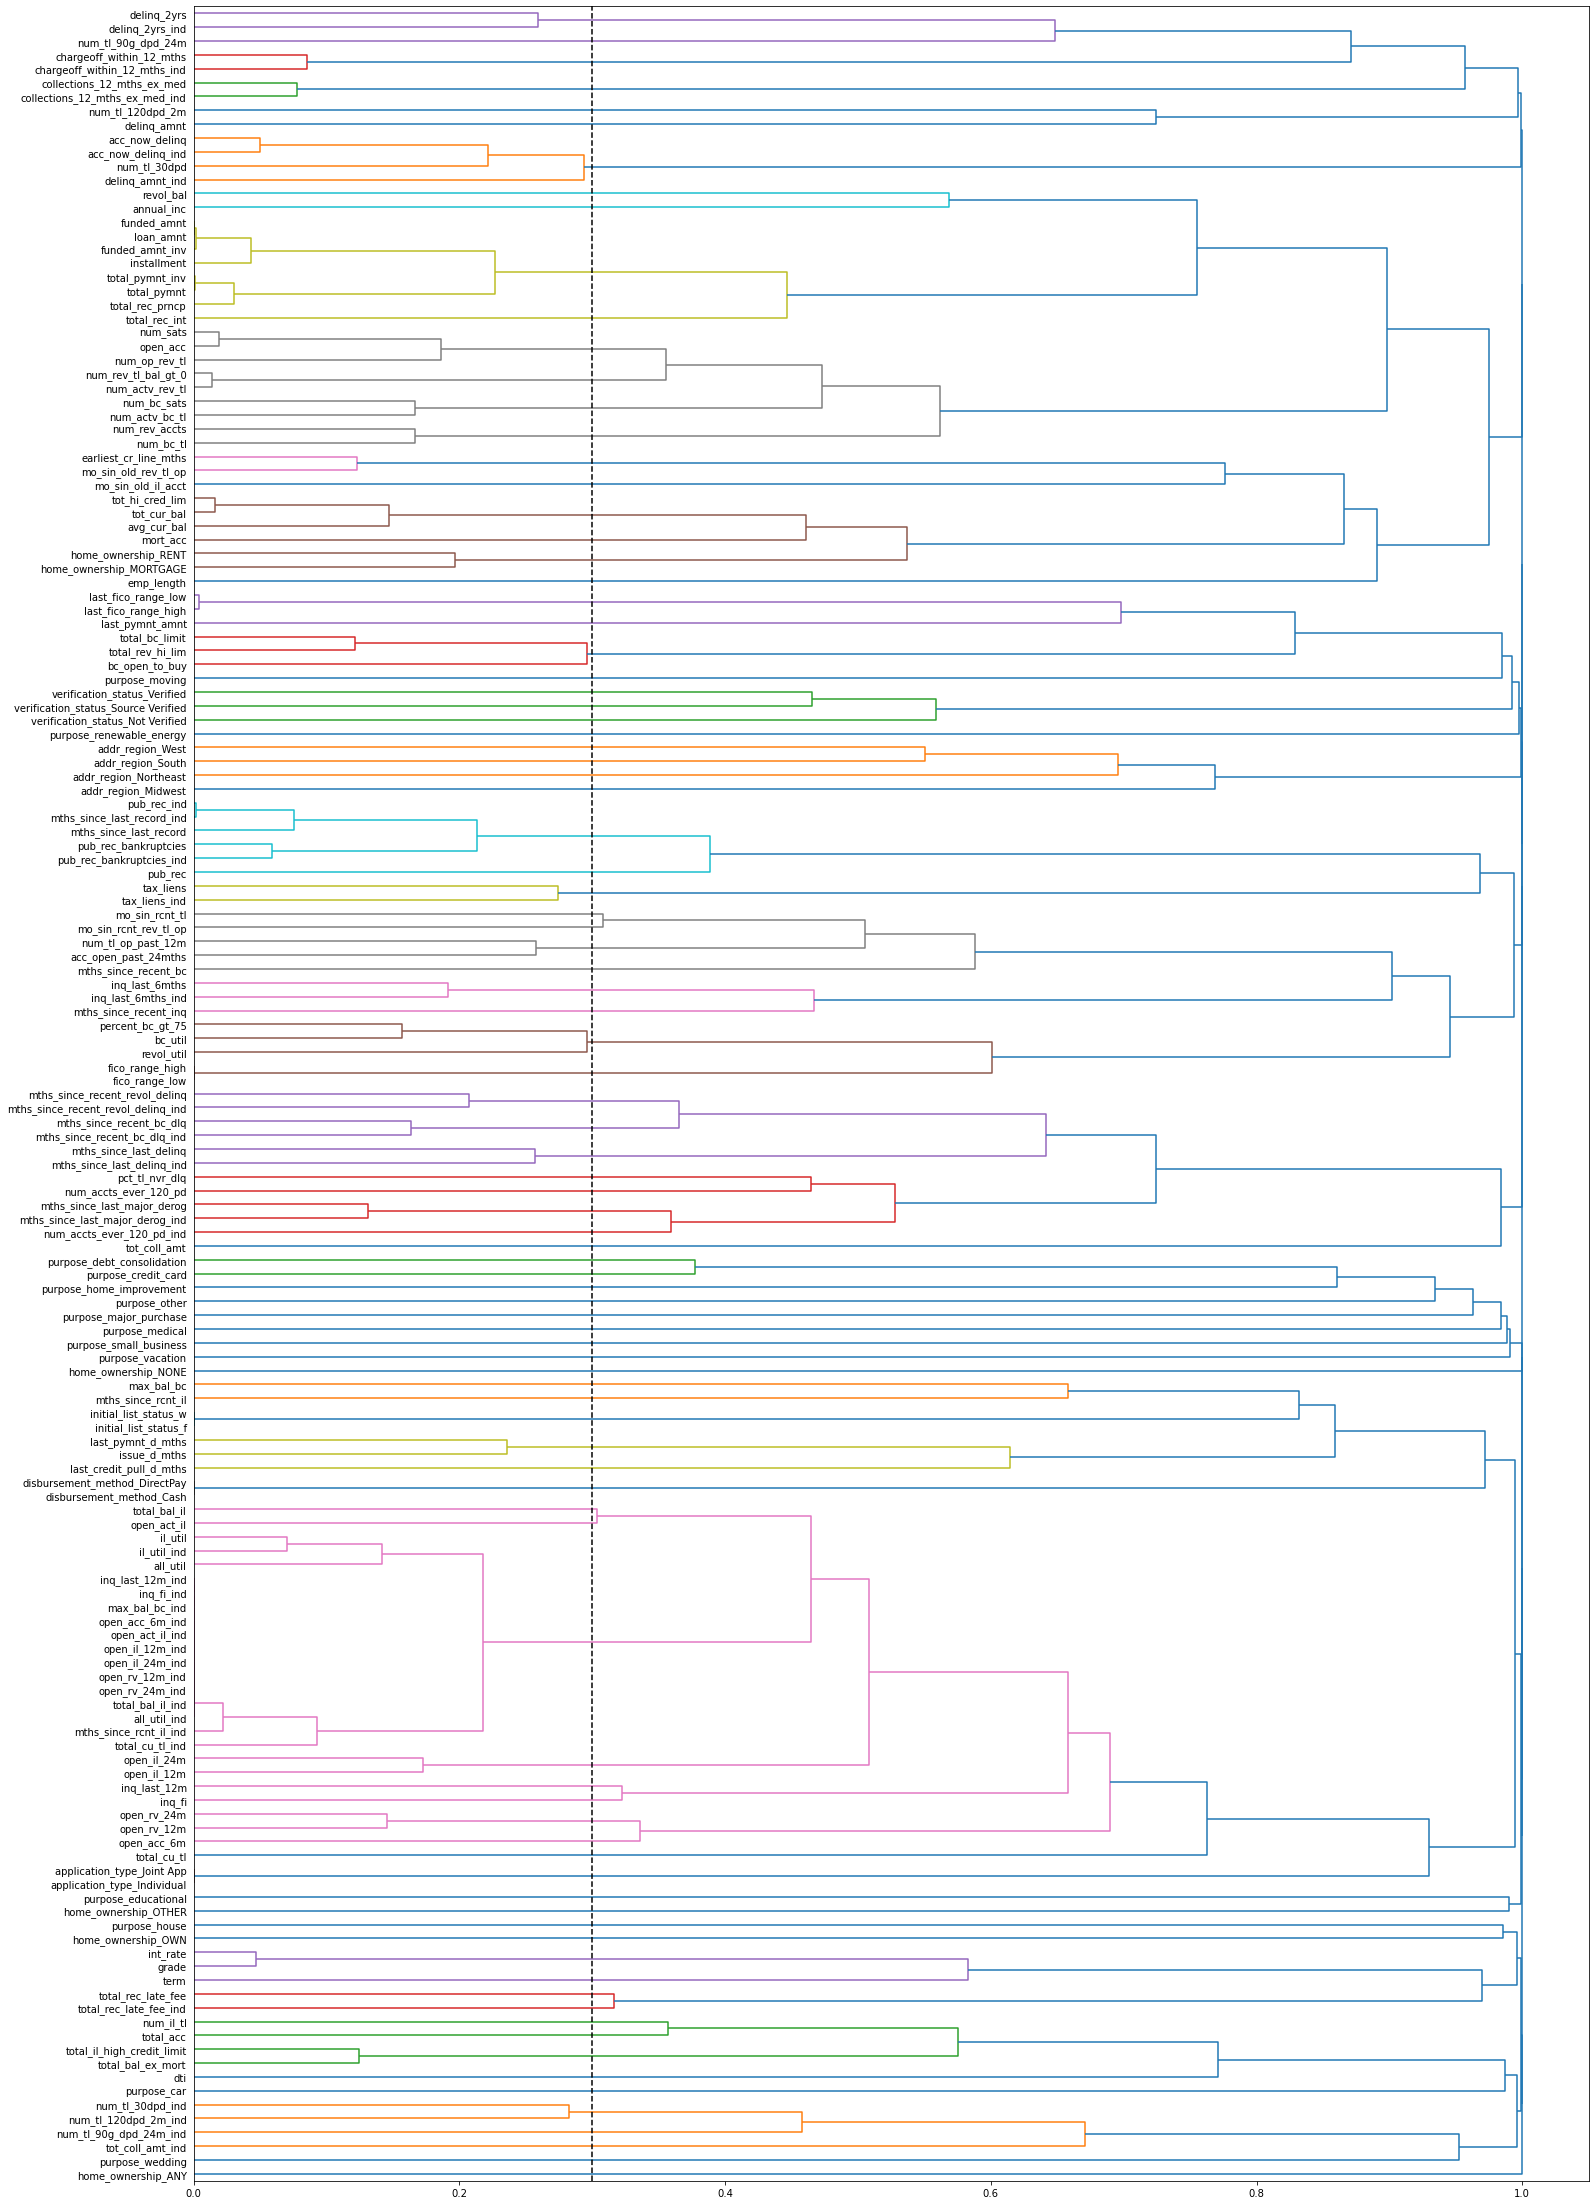

number of clusters: 95 at minimum correlation: 0.7


In [15]:
min_corr = 0.7
X_corr = new_X_train.corr().clip(-1, 1).values
X_cols = new_X_train.columns

X_cluster = correlation_dendrogram(X_corr, min_corr, X_cols)

### 2.5 Feature Selection: Random Forest Classifier

**Random Forecast Model** is selected in feature selection process:

   - able to handle imbalanced inputs 
   - less sensitive to correlated features comparing to regression based selection methods 
   - multi-subtree settings avoid missing information that could have been missed by single decision tree 

**Combine Result with Clustering**: 
It is noticed that variables from the same cluster, such as `fico scores (cluster 71)`, `current loan payment status (cluster 85)`, `loan grad (cluster 12)`, all have strong feature importance. To not missing information from these highly informative class of variables, all variables from top important clusters will be kept as modeling features. We decided to use XGBoost (i.e. less sensitive to correlated variables) to proceed with.

To generate modeling feature list: <br>
   - For each cluster *i*, compute $weighted\ score_i = $ $\frac{\sum_i(score)}{n_i}$
   - set `max_features` threshold: maximum features to keep
   - select features by clusters based on weighted_score


In [16]:
clf = RandomForestClassifier(max_depth=3, random_state=0)
clf.fit(new_X_train, new_y_train.values.ravel())
X_cluster['feat_ip'] = clf.feature_importances_

In [17]:
y_pred = clf.predict(new_X_test)
y_score = clf.predict_proba(new_X_test)[:, 1]

cmtrix = confusion_matrix(y_true=new_y_test.values, y_pred=y_pred)
fscore = f1_score(y_true=new_y_test.values, y_pred=y_pred)
auc = roc_auc_score(y_true=new_y_test.values, y_score=y_score)

print(f'confusion matrix:\n {cmtrix}')
print(f'f1_score: {fscore}')
print(f'auc: {auc}')

confusion matrix:
 [[107353    206]
 [ 12404  14568]]
f1_score: 0.6979351315096056
auc: 0.9822957732517881


In [84]:
X_cluster.sort_values('feat_ip', ascending=False).head(10)

,label,cluster,feat_ip
93,last_fico_range_low,71,0.22371
92,last_fico_range_high,71,0.15889
88,total_rec_prncp,85,0.13655
91,last_pymnt_amnt,72,0.11017
87,total_pymnt_inv,85,0.07649
73,int_rate,12,0.04062
86,total_pymnt,85,0.03921
1,grade,12,0.03128
69,total_rec_late_fee_ind,10,0.02692
90,total_rec_late_fee,11,0.01957


In [19]:
max_features = 50
feats, num_feats = feature_selection(X_cluster, max_features)
print(f'total number of features: {num_feats}')

total number of features: 50


### 2.6 Final Model: XGBoost

In [31]:
X_train_xgb = new_X_train[feats]
X_test_xgb = new_X_test[feats]
y_train_xgb = new_y_train.values.ravel()
y_test_xgb = new_y_test.values.ravel()

params = {
        'gamma': [0.0, 0.01, 0.1],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [2, 4, 8]
}

xgb = XGBClassifier(eta=0.3, n_estimators=100, eval_metric='logloss', use_label_encoder=False)

In [37]:
folds = 5
param_comb = 10

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state=1023)
random_search = RandomizedSearchCV(
    xgb, 
    param_distributions=params, 
    n_iter=param_comb, 
    scoring='f1', 
    n_jobs=4, 
    cv=skf.split(X_train_xgb, y_train_xgb), 
    verbose=3, 
    random_state=1023
)

random_search.fit(X_train_xgb, y_train_xgb)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x0000026F0CEF6350>,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, eta=0.3,
                                           eval_metric='logloss', gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_del...
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None,
                                           reg_alpha=None, reg_lambda=None,
 

In [44]:
print('Best estimator:\n')
print(random_search.best_estimator_)
print('Best parameters:\n')
print(random_search.best_params_)

Best estimator:

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, eta=0.3, eval_metric='logloss',
              gamma=0.01, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=8, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.6,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, ...)
Best parameters:

{'subsample': 0.6, 'max_depth': 8, 'gamma': 0.01, 'colsample_bytree': 0.8}


In [43]:
bst = random_search.best_estimator_

y_pred_xgb = bst.predict(X_test_xgb)
y_score_xgb = bst.predict_proba(xgb_X_test)[:, 1]

cmtrix = confusion_matrix(y_true=new_y_test.values, y_pred=y_pred_xgb)
fscore = f1_score(y_true=new_y_test.values, y_pred=y_pred_xgb)
auc = roc_auc_score(y_true=new_y_test.values, y_score=y_score_xgb)

print(f'confusion matrix:\n {cmtrix}\n')
print(f'f1_score: {fscore}\n')
print(f'auc: {auc}')

confusion matrix:
 [[107559      0]
 [    62  26910]]

f1_score: 0.9988493374410748

auc: 0.999909749686895


In [85]:
xgb_fi = pd.DataFrame({'feature': feats, 'score': bst.feature_importances_})
xgb_fi.sort_values('score',ascending=False).head(10)

,feature,score
33,last_fico_range_low,0.41450
32,last_fico_range_high,0.22040
5,inq_fi_ind,0.09545
19,funded_amnt,0.06790
31,last_pymnt_amnt,0.04540
28,total_rec_prncp,0.03839
0,term,0.03036
20,funded_amnt_inv,0.01468
26,total_pymnt,0.01190
44,last_pymnt_d_mths,0.00976


## 3. Findings & Conclusion

**FICO Score**: FICO turns out to be the most important feature in determining the likelihood of loan repayment. This makes intuitive business sense. Customers with higher credit score usually demonstrates a better credit history. Also, FICO score itself is a consolidated and derived credit score which contains many aspects of a borrower's risk profile. Investing in loans whose borrower having higher FICO score seems to be a safer choice for investors to avoid loss.

<AxesSubplot:xlabel='last_fico_range_high', ylabel='Probability'>

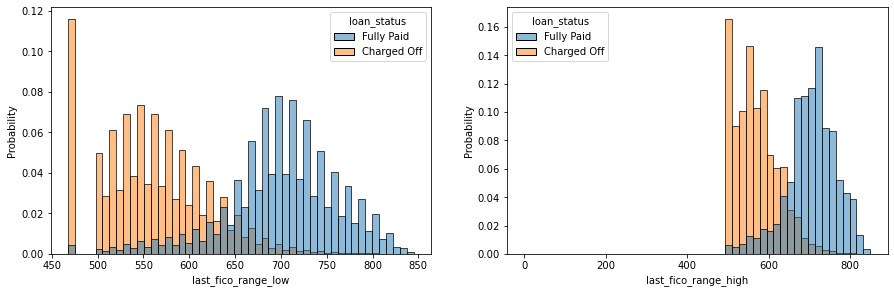

In [153]:
plot_num2(df=plot_data,var1='last_fico_range_low',var2='last_fico_range_high')

**Current Payment Status**: It is interesting that as of date payment status has strong indication of the loan repayment. Intuitively, if the principal of the loan has been paid down a lot, it indicates (1) the borrower has good history of paying back the loan; (2) less financial burden for the borrower to repay. For investor, if they are concerned with investing in long-termed loan, if possible, they can get into investment pool when the loan is approaching to maturity. 

`total_pymnt`: Payments received to date for total amount funded <br>
`total_rec_prncp`: Principal received to date
`term`: loam term (1 = 36 mths; 2 = 60 mths)

<AxesSubplot:xlabel='term', ylabel='Probability'>

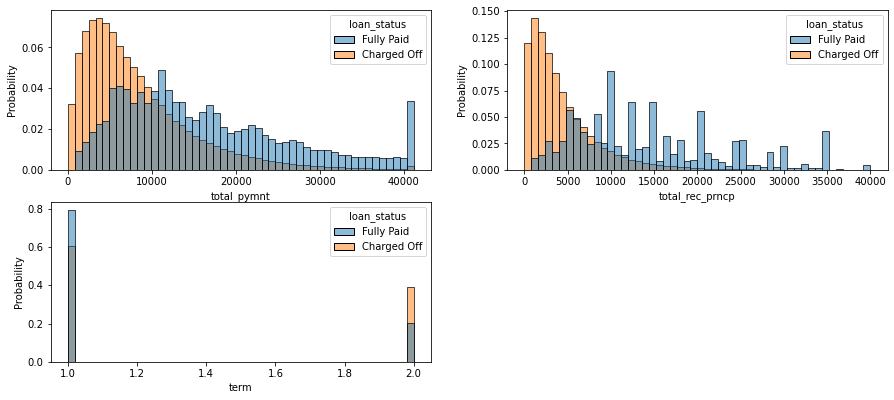

In [154]:
plot_num3(df=plot_data,var1='total_pymnt',var2='total_rec_prncp',var3='term')

**Loan Grade and Interest Rate**: Although as of date variables seems to provide higher predictivity over the loss event, investors may not have it if they want to fund the loan at earlier stage. From the feature importance and clustering result, `interest rate` and `grade` provides good indication in separating borrowers with fully-paid and charged-off.

Intuitively, loan with lower grade meaning that the borrower has higher risk in default, and thus, they are charged with higher interest rate as premium. Investor can use this information to balance their risk-reward investment strategy at very early stage of the loan (or even prior to actual issued date).  

`interest rate`: Interest Rate on the loan <br>
`grade`:LC assigned loan grade

<AxesSubplot:xlabel='int_rate', ylabel='Probability'>

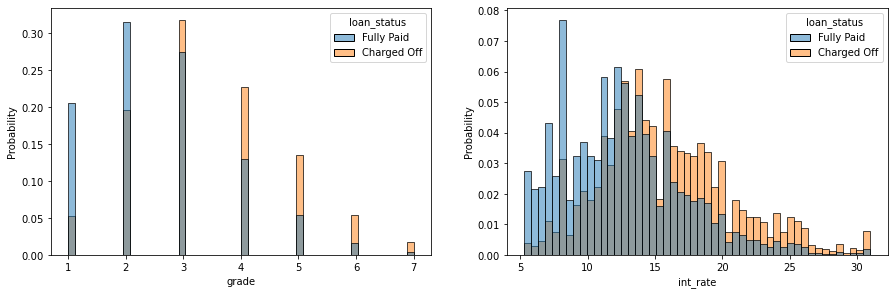

In [155]:
plot_num2(df=plot_data,var1='grade',var2='int_rate')

### 4. Limitations & Future Analysis

**Feature Engineering**:
- noticed that many variables are moderately correlated and associated with the same underlying event(i.e. made payments/delinquency/etc.) Variables can further consolidated or derived to combine multiple information together to lower variance.
- scalling (e.g. normalization) should be considered into the data pre-processing with cautious; More statistical testing or visualization could help to determine if any other transformation (i.e. log-scale) should be introduced

**Modeling**:
- Better understanding towards the datasets needs to be achieved if we would like to build an actual predictive model on loss event. Information in data dictionary is unclear for some variables.
- Other feature selection and modeling methods can be tested out to compare the performance.